# Importação dos dados

In [1]:
!pip install keras==2.3.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.8/377.8 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.0 requires keras>=3.2.0, but you have keras 2.3.1 which is incompatible.


## Carregar os dados

In [64]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# Conectando ao Google Drive
drive.mount('/content/drive')

# Carregando o arquivo .h5
with h5py.File('/content/drive/MyDrive/data/combined_data.h5', 'r') as h5f:
    X_data = h5f['X'][:]
    Y_data = h5f['Y'][:]

# Convertendo os dados para arrays numpy
X_data = np.array(X_data)
y_data = np.array(Y_data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pré-Processamento

## Corte de imagens

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
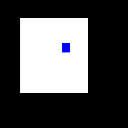

In [3]:
y_data[1]

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Função para ajustar o brilho e contraste
def adjust_brightness_contrast(image, brightness=20, contrast=20):
    alpha = contrast / 127 + 1  # Controla o contraste (1.0 = sem mudança)
    beta = brightness  # Controla o brilho (0 = sem mudança)
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

# Função para remover imagens muito claras e ajustar contraste para as muito escuras
def process_images(X, y, remove_threshold=176):
    X_removed = []
    y_removed = []
    X_before_after = []  # Lista para armazenar pares de imagens (original, ajustada)
    X_processed = []  # Lista para armazenar todas as imagens processadas
    y_final = []

    for i in range(X.shape[0]):
        # Máscara da cabeça e olhos
        mask = y[i] > 0  # Considera pixels com valor maior que 0 (branco e azul)

        # Seleciona a região da cabeça
        head_region = X[i][mask]

        # Calcula a média da intensidade da cabeça
        head_mean_intensity = np.mean(head_region)

        if head_mean_intensity > remove_threshold:
            # Se a média for maior que o threshold de remoção, remover a imagem
            X_removed.append(X[i])
            y_removed.append(y[i])

        elif head_mean_intensity >= 0 and head_mean_intensity < 90:
            # Aplicar brilho 40 e contraste 45 para intensidade < 90
            brightness = 40
            contrast = 45
            adjusted_image = adjust_brightness_contrast(X[i], brightness, contrast)
            X_before_after.append((X[i], adjusted_image))  # Armazenar o par (original, ajustada)
            X_processed.append(adjusted_image)  # Armazenar a imagem ajustada
            y_final.append(y[i])
        elif head_mean_intensity >= 90 and head_mean_intensity < 105:
            # Aplicar brilho 25 e contraste 30 para intensidade entre 90 e 105
            brightness = 25
            contrast = 30
            adjusted_image = adjust_brightness_contrast(X[i], brightness, contrast)
            X_before_after.append((X[i], adjusted_image))
            X_processed.append(adjusted_image)  # Armazenar a imagem ajustada
            y_final.append(y[i])
        elif head_mean_intensity >= 105 and head_mean_intensity <= 110:
            # Aplicar brilho 20 e contraste 20 para intensidade entre 105 e 110
            brightness = 20
            contrast = 20
            adjusted_image = adjust_brightness_contrast(X[i], brightness, contrast)
            X_before_after.append((X[i], adjusted_image))
            X_processed.append(adjusted_image)  # Armazenar a imagem ajustada
            y_final.append(y[i])
        elif head_mean_intensity > 167:
            brightness = -5
            contrast = -5
            adjusted_image = adjust_brightness_contrast(X[i], brightness, contrast)
            X_before_after.append((X[i], adjusted_image))
            X_processed.append(adjusted_image)
            y_final.append(y[i])
        else:
            # Se não for removida ou ajustada, manter a original
            X_processed.append(X[i])  # Armazenar a imagem original inalterada
            y_final.append(y[i])

    return X_removed, X_before_after, np.array(X_processed), np.array(y_final)

# Aplicar o processamento de imagens e armazenar o resultado processado
X_removed, X_before_after, X_processed, y_final = process_images(X_data, y_data, remove_threshold=176)


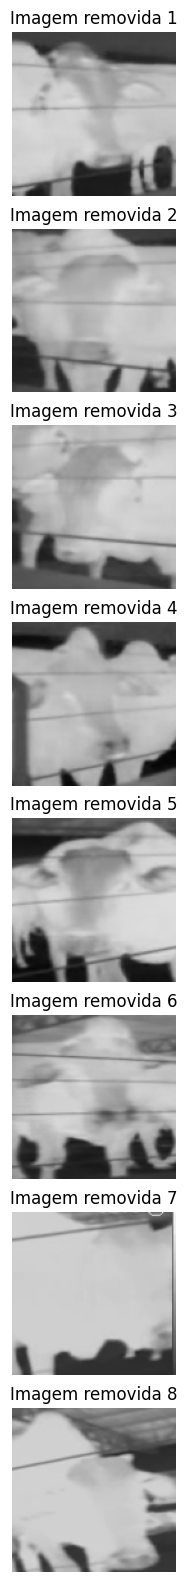

In [5]:
# Função para visualizar as imagens removidas
def visualize_removed_images(X_removed, num_images=5):
    num_imagens_para_mostrar = min(len(X_removed), num_images)
    plt.figure(figsize=(10, 20))  # Ajustar o tamanho da figura para o layout vertical
    for i in range(num_imagens_para_mostrar):
        plt.subplot(num_imagens_para_mostrar, 1, i + 1)  # Configurar subtramas em uma coluna
        plt.imshow(X_removed[i], cmap='gray')
        plt.title(f'Imagem removida {i+1}')
        plt.axis('off')
    plt.show()

# Visualizar as imagens removidas
visualize_removed_images(X_removed, num_images=12)

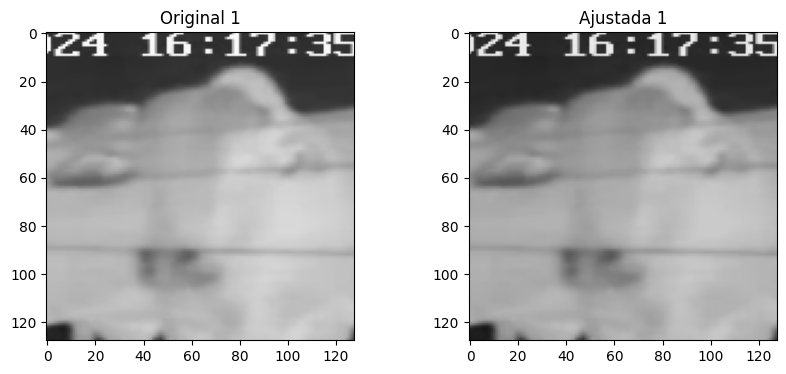

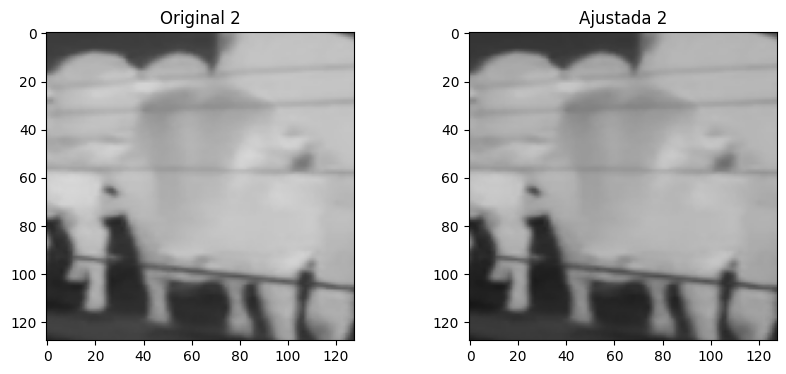

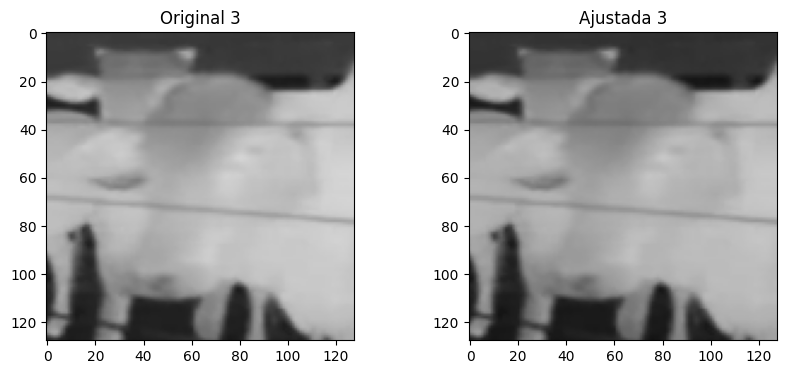

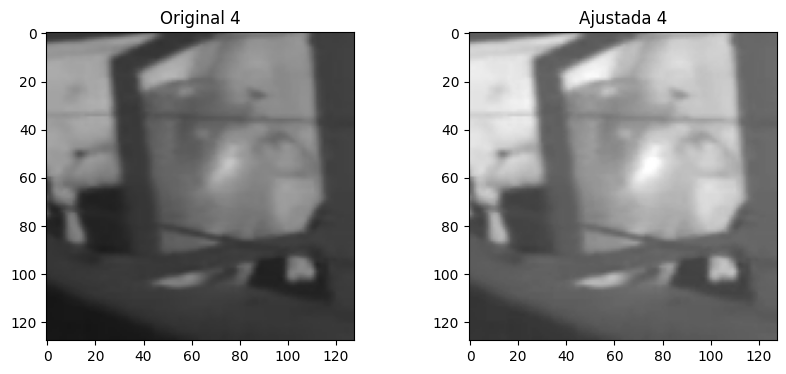

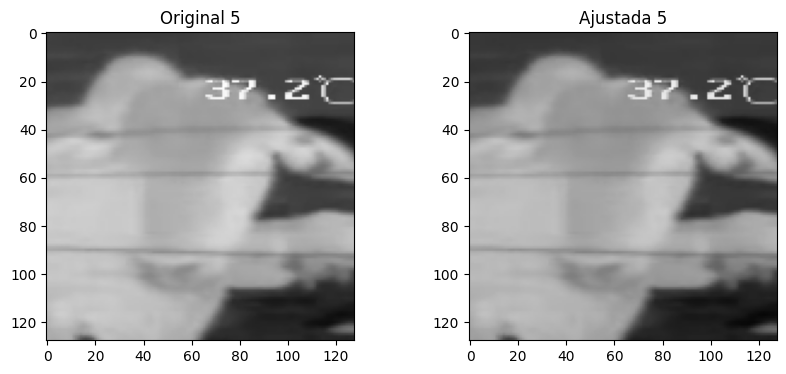

In [6]:
# Função para visualizar antes e depois do ajuste de brilho e contraste
def visualize_brightness_contrast(X_before_after, num_images=5):
    num_imagens_para_mostrar = min(len(X_before_after), num_images)
    for i in range(num_imagens_para_mostrar):
        original, adjusted = X_before_after[i]

        # Plotando a imagem original e ajustada
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(original, cmap='gray')
        plt.title(f'Original {i+1}')

        plt.subplot(1, 2, 2)
        plt.imshow(adjusted, cmap='gray')
        plt.title(f'Ajustada {i+1}')

        plt.show()

# Visualizar a comparação das imagens ajustadas (antes e depois)
visualize_brightness_contrast(X_before_after, num_images=5)


## Separação entre treino e teste

In [7]:
from sklearn.model_selection import train_test_split

# Separar dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_final, test_size=0.2, random_state=42)

# Exibindo o tamanho de cada conjunto
print(f'Tamanho do conjunto de treino: {X_train.shape[0]} imagens')
print(f'Tamanho do conjunto de teste: {X_test.shape[0]} imagens')

Tamanho do conjunto de treino: 1929 imagens
Tamanho do conjunto de teste: 483 imagens


## Data Augmentation

In [8]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def apply_data_augmentation(X, y, variations=2):

    X_augmented = []
    y_augmented = []

    datagen = ImageDataGenerator(
        rotation_range=5,
        zoom_range=0.2,
        width_shift_range=0.05,
        height_shift_range=0.05,
        brightness_range=[0.8, 1.2],
        channel_shift_range=50,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest'
    )

    for i in range(X.shape[0]):

        image = X[i]
        mask = y[i]

        X_augmented.append(image)
        y_augmented.append(mask)

        for j in range(variations):

            params = datagen.get_random_transform(image.shape)
            augmented_image = datagen.apply_transform(image, params)

            X_augmented.append(augmented_image)
            y_augmented.append(mask)

    return np.array(X_augmented), np.array(y_augmented)

X_train_new, y_train_new = apply_data_augmentation(X_train, y_train)

In [10]:
X_train_new.shape

(5787, 128, 128, 3)

 ## Normalização

In [11]:
# Normalizando os dados
X_train_normalized = X_train_new / 255.0
X_test_normalized = X_test / 255.0

In [12]:
# Convertendo para escala de cinza
X_train_normalized = np.mean(X_train_normalized, axis=-1, keepdims=True)
X_test_normalized = np.mean(X_test_normalized, axis=-1, keepdims=True)
y_train_new = np.mean(y_train_new, axis=-1, keepdims=True)
y_test = np.mean(y_test, axis=-1, keepdims=True)

In [13]:
# Converter y_train_new e y_test para float32
X_train_normalized = X_train_normalized.astype('float32')
X_test_normalized = X_test_normalized.astype('float32')
y_train_new = y_train_new.astype('float32')
y_test = y_test.astype('float32')

In [14]:
# Função para converter imagens de 1 canal (grayscale) para 3 canais (RGB)
def convert_grayscale_to_rgb(X):
    X_rgb = np.repeat(X, 3, axis=-1)
    return X_rgb

# Converter os dados de treino e teste de escala de cinza para RGB
X_train_rgb = convert_grayscale_to_rgb(X_train_normalized)
X_test_rgb = convert_grayscale_to_rgb(X_test_normalized)
y_train_rgb = convert_grayscale_to_rgb(y_train_new)
y_test_rgb = convert_grayscale_to_rgb(y_test)

# Função para construção dos modelos

In [36]:
# Função para criar o modelo U-Net (mantida a mesma do código anterior)
def unet_simplified(input_size):
    inputs = Input(shape=img_size + (3,))

    # Downsampling - Parte de Contração
    c1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)

    # Upsampling - Parte de Expansão
    u4 = UpSampling2D(size=(2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(u4)
    c4 = BatchNormalization()(c4)

    u5 = UpSampling2D(size=(2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)

    # Saída com apenas 1 canal (segmentação binária)
    outputs = Conv2D(1, kernel_size=1, activation='sigmoid')(c5)

    # Definindo o modelo
    model = Model(inputs, outputs)

    return model

In [29]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras.applications import vgg16
from keras.models import Model, load_model
import keras
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from numpy.random import seed
import tensorflow as tf
import time
from keras import backend as K
import h5py

In [37]:
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Activation

import tensorflow as tf

# Define the Dice Loss function
img_size = (128, 128)

# Compilando o modelo com as métricas corrigidas
model = unet_simplified(input_size=(128, 128, 1))


# Compilando o modelo com as métricas corrigidas
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=["accuracy"])

# Callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6),
]

batch_size = 32
X_train_rgb = np.repeat(X_train_normalized, 3, axis=-1)  # Converter para 3 canais
X_test_rgb = np.repeat(X_test_normalized, 3, axis=-1)  # Converter para 3 canais
# Treinando o modelo
history = model.fit(X_train_rgb, y_train_new,
                    validation_data=(X_test_rgb, y_test),
                    batch_size=32,
                    steps_per_epoch=len(X_train_rgb) // batch_size,
                    epochs=50,
                    callbacks=callbacks)




Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.3497 - loss: -599.5856 - val_accuracy: 1.2144e-04 - val_loss: -1983.3569 - learning_rate: 0.0010
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 781us/step - accuracy: 0.3421 - loss: -1348.9276 - val_accuracy: 5.7244e-05 - val_loss: -2135.2537 - learning_rate: 0.0010
Epoch 3/50
  1/180 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.3551 - loss: -1425.8259

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3455 - loss: -1777.0452 - val_accuracy: 0.0703 - val_loss: -5363.0635 - learning_rate: 0.0010
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.3414 - loss: -3362.5825 - val_accuracy: 0.0559 - val_loss: -5754.4482 - learning_rate: 0.0010
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3409 - loss: -3631.1221 - val_accuracy: 0.2071 - val_loss: -10099.7949 - learning_rate: 0.0010
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.3329 - loss: -5395.7935 - val_accuracy: 0.2169 - val_loss: -10108.2900 - learning_rate: 0.0010
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3343 - loss: -6338.4541 - val_accuracy: 0.3358 - val_loss: -8791.0938 - learning_rate: 0.0010
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.3314 - loss: -8779.6709 - val_accuracy: 0.3336 - val_loss: -10192.9170 - learning_rate: 0.0010
Epoch 9/50
180/180 ━━━━━━━━━━━━━━━━━━━━

InvalidArgumentError: Graph execution error:

Detected at node convolution defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-37-d5922bf0536f>", line 35, in <cell line: 35>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 433, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 154, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 82, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 560, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 243, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 233, in convolution_op

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 901, in conv

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 256, in conv

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 244, in _conv_xla

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 231, in _conv

Depth of input must be a multiple of depth of filter: 1 vs 3

Stack trace for op definition: 
File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "<ipython-input-37-d5922bf0536f>", line 35, in <cell line: 35>
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 433, in evaluate
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 154, in one_step_on_data
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 82, in test_step
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 560, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 243, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 233, in convolution_op
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 901, in conv
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 256, in conv
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 244, in _conv_xla
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 231, in _conv

	 [[{{node convolution}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_179334[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_179411]

In [ ]:
# Avaliação do modelo
model.evaluate(X_test_normalized, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


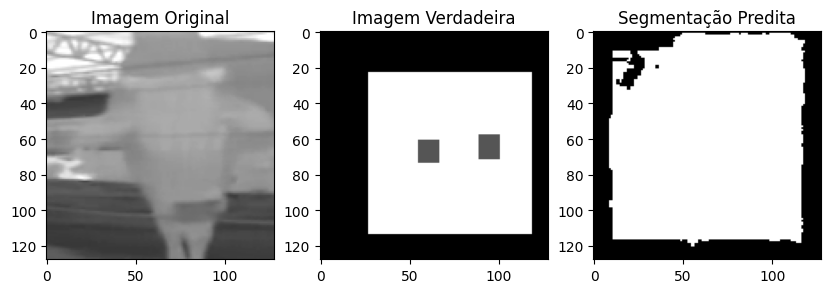

In [44]:
# Exibindo a segmentação de uma imagem
def plot_prediction(model, X, Y, index):
    pred = model.predict(np.expand_dims(X[index], axis=0))
    pred = (pred > 0.5).astype(np.uint8)  # Binarizando a predição

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(X[index])
    plt.title('Imagem Original')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(Y[index]), cmap='gray')
    plt.title('Imagem Verdadeira')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred), cmap='gray')
    plt.title('Segmentação Predita')

    plt.show()

# Exemplo de predição
plot_prediction(model, X_test_rgb, y_test, index=8)

In [65]:
from tensorflow.keras.layers import Multiply, Add, UpSampling2D, Conv2D


# Converter os dados de treino e teste de escala de cinza para RGB
X_train_rgb_new = convert_grayscale_to_rgb(X_train)
X_test_rgb_new = convert_grayscale_to_rgb(X_test)
y_train_rgb_new = convert_grayscale_to_rgb(y_train)
y_test_rgb_new = convert_grayscale_to_rgb(y_test)

# Função de atenção
def attention_block(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, kernel_size=1, strides=1, padding='same')(x)
    phi_g = Conv2D(inter_channel, kernel_size=1, strides=1, padding='same')(g)
    add_xg = Add()([theta_x, phi_g])
    relu_xg = Activation('relu')(add_xg)
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same')(relu_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    return Multiply()([x, sigmoid_xg])

def unet_with_attention(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Downsampling - Parte de Contração
    c1 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(128, kernel_size=3, activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)

    # Bloco de Atenção (corrigido para ajustar a forma de saída)
    attention_c3 = attention_block(c3, p2, 64)

    # Upsampling - Parte de Expansão
    u4 = UpSampling2D(size=(2, 2))(attention_c3)
    u4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(u4)  # Adicionando convolução para ajustar o número de canais
    u4 = concatenate([u4, c2], axis=-1)
    c4 = Conv2D(64, kernel_size=3, activation='relu', padding='same')(u4)
    c4 = BatchNormalization()(c4)

    u5 = UpSampling2D(size=(2, 2))(c4)
    u5 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(u5)  # Ajustando número de canais aqui também
    u5 = concatenate([u5, c1], axis=-1)
    c5 = Conv2D(32, kernel_size=3, activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)

    # Saída com apenas 1 canal (segmentação binária)
    outputs = Conv2D(1, kernel_size=1, activation='sigmoid')(c5)

    # Definindo o modelo
    model = Model(inputs, outputs)

    return model

# Compilar o modelo
model_with_attention = unet_with_attention(input_size=(128, 128, 3))
model_with_attention.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=["accuracy"])

# Treinamento do modelo
history_attention = model_with_attention.fit(
    X_train_rgb_new, y_train_new,  # Garantindo que Y tem 1 canal
    validation_data=(X_test_rgb_new, y_test),
    batch_size=32,
    steps_per_epoch=len(X_train_rgb_new) // 32,
    epochs=50,
    callbacks=callbacks
)



ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 1929
'y' sizes: 5787


In [60]:
def convert_grayscale_to_rgb(X):
    # Repetir o canal de cinza três vezes para criar uma imagem RGB
    return np.repeat(X, 3, axis=-1)

# Agora aplicando corretamente a função
X_train_rgb_new = convert_grayscale_to_rgb(X_train)
X_test_rgb_new = convert_grayscale_to_rgb(X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


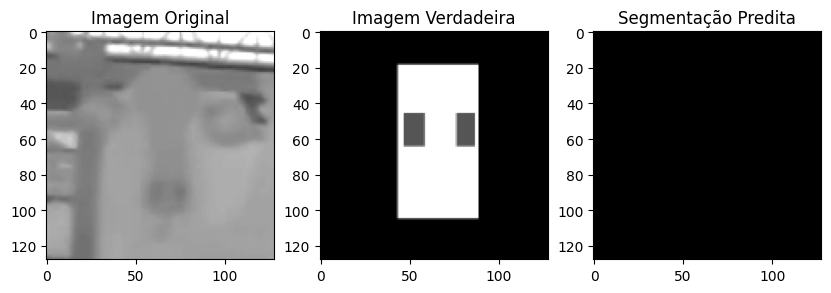

In [55]:
# Exibindo a segmentação de uma imagem
def plot_prediction(model, X, Y, index):
    pred = model.predict(np.expand_dims(X[index], axis=0))
    pred = (pred > 0.5).astype(np.uint8)  # Binarizando a predição

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(X[index])
    plt.title('Imagem Original')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(Y[index]), cmap='gray')
    plt.title('Imagem Verdadeira')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred), cmap='gray')
    plt.title('Segmentação Predita')

    plt.show()

# Exemplo de predição
plot_prediction(model_with_attention, X_test_rgb, y_test, index=45)

## 1. Rede Neural Própria (Custom CNN) [U-Net]

In [15]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU

def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs, outputs)
    return model

# Compilar o modelo
unet = unet_model()
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
unet.summary()





Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 16, 16, 1024)   │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 1536)   │              0 │ up_sampling2d[0][0],   │
│                      

 Total params: 31,377,793 (119.70 MB)

 Trainable params: 31,377,793 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

Treinando U-Net...
Epoch 1/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 56s 170ms/step - loss: nan - mean_io_u: 0.3442 - val_loss: nan - val_mean_io_u: 0.5000
Epoch 2/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: nan - mean_io_u: 0.5027 - val_loss: nan - val_mean_io_u: 0.5000
Epoch 3/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: nan - mean_io_u: 0.5000 - val_loss: nan - val_mean_io_u: 0.5000
Epoch 4/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: nan - mean_io_u: 0.5027 - val_loss: nan - val_mean_io_u: 0.5000
Epoch 5/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: nan - mean_io_u: 0.5000 - val_loss: nan - val_mean_io_u: 0.5000
Epoch 6/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: nan - mean_io_u: 0.5000 - val_loss: nan - val_mean_io_u: 0.5000
Epoch 7/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: nan - mean_io_u: 0.5000 - val_loss: nan - val_mean_io_u: 0.5000
Epoch 8/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: nan - mean_io_u: 0.5027 - val_loss: nan - v

KeyError: 'iou_score'

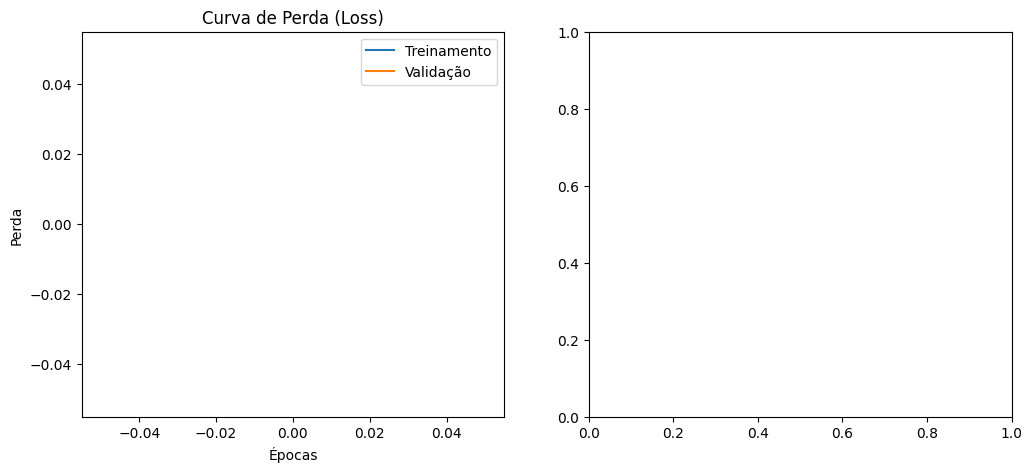

In [16]:
# Treinamento dos Modelos

# 1. U-Net
print("Treinando U-Net...")
# Treinamento do modelo U-Net
# Como o modelo já está compilado, vamos treiná-lo diretamente

# Definir parâmetros de treinamento
epochs = 20  # número de épocas de treinamento
batch_size = 32  # tamanho do batch para cada iteração de treinamento

# Realizar o treinamento
unet_history = unet.fit(
    X_train_normalized,  # dados de entrada para treinamento
    y_train_new,  # rótulos de saída para treinamento
    validation_data=(X_test_normalized, y_test),  # dados de validação
    epochs=epochs,  # número de épocas de treinamento
    batch_size=batch_size,  # tamanho do batch
    verbose=1  # exibe o progresso do treinamento
)



In [ ]:
# Salvar o histórico do treinamento para análise posterior
import matplotlib.pyplot as plt

# Plotar as curvas de perda (loss) e métrica IoU
plt.figure(figsize=(12, 5))

# Perda (loss)
plt.subplot(1, 2, 1)
plt.plot(unet_history.history['loss'], label='Treinamento')
plt.plot(unet_history.history['val_loss'], label='Validação')
plt.title('Curva de Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# IoU (Intersection over Union)
plt.subplot(1, 2, 2)
plt.plot(unet_history.history['iou_score'], label='Treinamento')
plt.plot(unet_history.history['val_iou_score'], label='Validação')
plt.title('Curva de IoU')
plt.xlabel('Épocas')
plt.ylabel('IoU')
plt.legend()

plt.show()


## 2. U-Net++

In [18]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.2.1
!pip install keras==2.3.1
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0)
ERROR: No matching distribution found for tensorflow==2.2.1
  Using cached Keras-2.3.1-py2.py3-none-any.whl.metadata (2.2 kB)
Using cached Keras-2.3.1-py2.py3-none-any.whl (377 kB)
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavi

Segmentation Models: using `tf.keras` framework.


In [19]:
from segmentation_models import Unet

# Usando U-Net++ com encoder VGG16
unet_plus_plus = Unet(backbone_name='vgg16', encoder_weights='imagenet', decoder_block_type='upsampling')

# Compilando o modelo
unet_plus_plus.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
unet_plus_plus.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, None, None, 64) │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, None, None, 64) │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, None, None, 64) │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, None, None,     │         73,856 │ block1_pool[0][0]      │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, None, None,     │        147,584 │ block2_conv1[0][0]     │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, None, None,     │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, None, None,     │        295,168 │ block2_pool[0][0]      │
│                           │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, None, None,     │        590,080 │ block3_conv1[0][0]     │
│                           │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, None, None,     │        590,080 │ block3_conv2[0][0]     │
│                           │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, None, None,     │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, None, None,     │      1,180,160 │ block3_pool[0][0]      │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, None, None,     │      2,359,808 │ block4_conv1[0][0]     │
│                           │ 512)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, None, None,     │      2,359,808 │ block4_conv2[0][0]     │
│                      

 Total params: 23,752,273 (90.61 MB)

 Trainable params: 23,748,241 (90.59 MB)

 Non-trainable params: 4,032 (15.75 KB)

In [22]:
import gc
import tensorflow as tf

# Limpar variáveis que não estão mais sendo usadas
gc.collect()


# Função para converter imagens de 1 canal (grayscale) para 3 canais (RGB)
def convert_grayscale_to_rgb(X):
    X_rgb = np.repeat(X, 3, axis=-1)
    return X_rgb

# Converter os dados de treino e teste de escala de cinza para RGB
X_train_rgb = convert_grayscale_to_rgb(X_train_normalized)
X_test_rgb = convert_grayscale_to_rgb(X_test_normalized)

# Verificar as novas formas dos dados
print(f"Shape of X_train_rgb: {X_train_rgb.shape}")
print(f"Shape of X_test_rgb: {X_test_rgb.shape}")

# Treinamento do U-Net++
print("Treinando U-Net++...")

# Definir parâmetros de treinamento
epochs = 20  # número de épocas de treinamento
batch_size = 32  # tamanho do batch para cada iteração de treinamento

# Callbacks (opcional) para melhorar o treinamento
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.CSVLogger('training_log.csv', separator=",", append=False)  # Substitui o ModelCheckpoint
]


# Treinar o modelo U-Net++ com as imagens RGB
unet_plus_plus_history = unet_plus_plus.fit(
    X_train_rgb,  # dados de entrada para treinamento (agora com 3 canais)
    y_train_new,  # rótulos de saída para treinamento
    validation_data=(X_test_rgb, y_test),  # dados de validação (com 3 canais)
    epochs=epochs,  # número de épocas de treinamento
    batch_size=batch_size,  # tamanho do batch
    verbose=1,  # exibe o progresso do treinamento
    callbacks=callbacks  # adiciona callbacks
)

# Salvar o histórico do treinamento em um arquivo
import pandas as pd

# Converter o histórico para um DataFrame e salvar como CSV
unet_plus_plus_history_df = pd.DataFrame(unet_plus_plus_history.history)
unet_plus_plus_history_df.to_csv('unet_plus_plus_training_history.csv', index=False)

# Verificar as métricas do treinamento final
unet_plus_plus_history_df.head()


Shape of X_train_rgb: (5787, 128, 128, 3)
Shape of X_test_rgb: (483, 128, 128, 3)
Treinando U-Net++...
Epoch 1/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 43s 120ms/step - loss: -679.6003 - mean_io_u_1: 0.4796 - val_loss: -40228.5312 - val_mean_io_u_1: 0.2241
Epoch 2/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: -6033.5366 - mean_io_u_1: 0.3993 - val_loss: -35.0687 - val_mean_io_u_1: 0.5000
Epoch 3/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: -15539.0361 - mean_io_u_1: 0.3762 - val_loss: -41023.1484 - val_mean_io_u_1: 0.3408
Epoch 4/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: -29062.0957 - mean_io_u_1: 0.3584 - val_loss: -70.8458 - val_mean_io_u_1: 0.4999
Epoch 5/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: -46686.0938 - mean_io_u_1: 0.3440 - val_loss: -795.4658 - val_mean_io_u_1: 0.4886
Epoch 6/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: -69354.6875 - mean_io_u_1: 0.3387 - val_loss: -117003.4922 - val_mean_io_u_1: 0.2156
Epoch 7/20
181/181 ━━━━━━━━━━━━━━━━

,loss,mean_io_u_1,val_loss,val_mean_io_u_1
0,-1657.523560,0.424777,-40228.531250,0.224143
1,-8066.905762,0.333422,-35.068695,0.499971
2,-18506.226562,0.305365,-41023.148438,0.340825
3,-33162.761719,0.287970,-70.845833,0.499897
4,-52001.214844,0.274731,-795.465820,0.488633


## 3. Attention U-Net

In [23]:
!pip uninstall tensorflow keras -y
!pip install tensorflow keras --upgrade


Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: Keras 2.3.1
Uninstalling Keras-2.3.1:
  Successfully uninstalled Keras-2.3.1
  Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached keras-3.5.0-py3-none-any.whl.metadata (5.8 kB)
Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (601.3 MB)
Using cached keras-3.5.0-py3-none-any.whl (1.1 MB)


In [24]:
from tensorflow.keras.layers import Multiply, Add, UpSampling2D, Conv2D, concatenate, MaxPooling2D, Activation, Input
from tensorflow.keras.models import Model

# Função de atenção ajustada para corresponder às dimensões
def attention_block(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, kernel_size=1, strides=1, padding='same')(x)
    phi_g = UpSampling2D(size=(2, 2))(Conv2D(inter_channel, kernel_size=1, strides=1, padding='same')(g))  # Ajuste no tamanho para corresponder a x
    add_xg = Add()([theta_x, phi_g])
    relu_xg = Activation('relu')(add_xg)
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same')(relu_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    return Multiply()([x, sigmoid_xg])

# Modelo Attention U-Net (baseado no U-Net anterior)
def attention_unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Encoder (como o U-Net)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder com blocos de atenção
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), attention_block(conv4, conv5, 512)], axis=-1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), attention_block(conv3, conv6, 256)], axis=-1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), attention_block(conv2, conv7, 128)], axis=-1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), attention_block(conv1, conv8, 64)], axis=-1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs, outputs)
    return model

# Compilar o modelo
attention_unet = attention_unet_model()
attention_unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])

attention_unet.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 128, 128, 64)   │            640 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 64)     │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 128)    │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 16, 16, 256)    │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 8, 8, 512)      │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 8, 8, 512)      │        524,800 │ conv2d_28[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 16, 16, 512)    │        262,656 │ conv2d_26[0][0]        │
├──────────────────────

 Total params: 29,290,757 (111.74 MB)

 Trainable params: 29,290,757 (111.74 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Parâmetros de treinamento
epochs = 20
batch_size = 32

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('attention_unet_best_model.keras', save_best_only=True, monitor='val_loss', mode='min'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs_attention_unet')
]

# Treinar o modelo Attention U-Net
attention_unet_history = attention_unet.fit(
    X_train_normalized,  # dados de entrada para treinamento
    y_train_new,  # rótulos de saída para treinamento
    validation_data=(X_test_normalized, y_test),  # dados de validação
    epochs=epochs,  # número de épocas de treinamento
    batch_size=batch_size,  # tamanho do batch
    callbacks=callbacks,  # callbacks
    verbose=1  # exibe o progresso do treinamento
)

# Avaliar no conjunto de teste
score = attention_unet.evaluate(X_test_normalized, y_test)
print(f"Test Loss: {score[0]}, Test MeanIoU: {score[1]}")


Epoch 1/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 35s 109ms/step - loss: nan - mean_io_u_2: 0.2755 - val_loss: nan - val_mean_io_u_2: 0.5000
Epoch 2/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: nan - mean_io_u_2: 0.5000 - val_loss: nan - val_mean_io_u_2: 0.5000
Epoch 3/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: nan - mean_io_u_2: 0.5027 - val_loss: nan - val_mean_io_u_2: 0.5000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: nan - mean_io_u_2: 0.5588
Test Loss: nan, Test MeanIoU: 0.4999707043170929


## 4. VGG16 + U-Net

In [ ]:
!pip uninstall keras tensorflow -y
!pip install keras tensorflow


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import MeanIoU

def vgg16_unet_model(input_size=(128, 128, 3)):
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_size)

    # Congelando as camadas do VGG16
    for layer in vgg16.layers:
        layer.trainable = False

    inputs = vgg16.input

    # Camadas intermediárias do VGG16
    conv4 = vgg16.get_layer("block4_conv3").output
    conv5 = vgg16.get_layer("block5_conv3").output

    # Decoder (adicionando mais camadas de upsampling para ajustar a saída)
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)

    # Saída final com a mesma dimensão que os rótulos (128x128)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Compilar o modelo com a métrica ajustada para MeanIoU
vgg16_unet = vgg16_unet_model()
vgg16_unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
vgg16_unet.summary()



In [ ]:
# TREINAMENTO

# Callbacks para EarlyStopping e ModelCheckpoint
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('vgg16_unet_best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
]

# Treinamento do modelo
vgg16_unet_history = vgg16_unet.fit(
    X_train_rgb,  # dados de entrada (3 canais)
    y_train_new,  # rótulos de saída (1 canal)
    validation_data=(X_test_rgb, y_test),  # dados de validação
    epochs=20,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Avaliação no conjunto de teste
score = vgg16_unet.evaluate(X_test_rgb, y_test)
print(f"Test Loss: {score[0]}, Test MeanIoU: {score[1]}")

## 5. ResNet + U-Net

In [ ]:
from tensorflow.keras.applications import ResNet50

def resnet_unet_model(input_size=(128, 128, 3)):
    resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_size)

    # Congelando as camadas do ResNet50
    for layer in resnet50.layers:
        layer.trainable = False

    inputs = resnet50.input

    # Camadas intermediárias do ResNet50
    conv4 = resnet50.get_layer("conv4_block6_2_relu").output
    conv5 = resnet50.get_layer("conv5_block3_out").output

    # Decoder (como o U-Net)
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Compilar o modelo
resnet_unet = resnet_unet_model()
resnet_unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resnet_unet.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Parâmetros de treinamento
epochs = 20
batch_size = 32

# Callbacks para parar o treinamento cedo e salvar o melhor modelo
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('resnet_unet_best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
]

# Treinamento do modelo ResNet + U-Net
print("Treinando ResNet + U-Net...")
resnet_unet_history = resnet_unet_model.fit(
    X_train_rgb,   # Dados de entrada (RGB)
    y_train_new,   # Rótulos de saída
    validation_data=(X_test_rgb, y_test),  # Dados de validação
    epochs=epochs,  # Número de épocas
    batch_size=batch_size,  # Tamanho do batch
    callbacks=callbacks,  # Lista de callbacks
    verbose=1  # Exibir progresso
)

# Avaliação no conjunto de teste
score = resnet_unet_model.evaluate(X_test_rgb, y_test)
print(f"Test Loss: {score[0]}, Test Accuracy: {score[1]}")

## 6. U-Net, FPN, LinkNet, e PSPNet

In [ ]:
!pip install segmentation-models


In [ ]:
import cv2
import numpy as np

# Função para redimensionar as imagens para 144x144 com ajuste de canal
def resize_images_for_pspnet(X, new_size=(144, 144)):
    X_resized = np.zeros((X.shape[0], new_size[0], new_size[1], X.shape[3]))
    for i in range(X.shape[0]):
        # Redimensionando e garantindo que a saída seja (144, 144, 1)
        resized_img = cv2.resize(X[i], new_size)
        if len(resized_img.shape) == 2:  # Se a imagem é 2D, adiciona o canal extra
            resized_img = np.expand_dims(resized_img, axis=-1)
        X_resized[i] = resized_img
    return X_resized

# Redimensionando o X_train e X_test apenas para o PSPNet
X_train_resized_pspnet = resize_images_for_pspnet(X_train_normalized, (144, 144))
X_test_resized_pspnet = resize_images_for_pspnet(X_test_normalized, (144, 144))


In [ ]:
from segmentation_models import Unet, FPN, Linknet, PSPNet
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

# U-Net com encoder ResNet34, sem pesos pretreinados
unet_model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(128, 128, 1))
unet_model.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=[iou_score])

# FPN com encoder EfficientNetB3, sem pesos pretreinados
fpn_model = FPN(backbone_name='efficientnetb3', encoder_weights=None, input_shape=(128, 128, 1))
fpn_model.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=[iou_score])

# LinkNet com encoder InceptionV3, sem pesos pretreinados
linknet_model = Linknet(backbone_name='inceptionv3', encoder_weights=None, input_shape=(128, 128, 1))
linknet_model.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=[iou_score])

# PSPNet com encoder ResNet50, sem pesos pretreinados
pspnet_model = PSPNet(backbone_name='resnet50', encoder_weights=None, input_shape=(144, 144, 1))
pspnet_model.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=[iou_score])

# Resumos dos modelos
unet_model.summary()
fpn_model.summary()
linknet_model.summary()
pspnet_model.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Parâmetros de treinamento
epochs = 20
batch_size = 32

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
]

# 1. U-Net com encoder ResNet34
print("Treinando U-Net com ResNet34...")
unet_history = unet_model.fit(
    X_train_normalized,  # Dados de entrada para U-Net (1 canal)
    y_train_new,         # Rótulos de saída (1 canal)
    validation_data=(X_test_normalized, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

# 2. FPN com encoder EfficientNetB3
print("Treinando FPN com EfficientNetB3...")
fpn_history = fpn_model.fit(
    X_train_normalized,  # Dados de entrada para FPN (1 canal)
    y_train_new,         # Rótulos de saída (1 canal)
    validation_data=(X_test_normalized, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

# 3. LinkNet com encoder InceptionV3
print("Treinando LinkNet com InceptionV3...")
linknet_history = linknet_model.fit(
    X_train_normalized,  # Dados de entrada para LinkNet (1 canal)
    y_train_new,         # Rótulos de saída (1 canal)
    validation_data=(X_test_normalized, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

# 4. PSPNet com encoder ResNet50 (144x144)
print("Treinando PSPNet com ResNet50...")
# Redimensionar o conjunto de dados para PSPNet
X_train_resized_pspnet = resize_images_for_pspnet(X_train_normalized, (144, 144))
X_test_resized_pspnet = resize_images_for_pspnet(X_test_normalized, (144, 144))

pspnet_history = pspnet_model.fit(
    X_train_resized_pspnet,  # Dados de entrada redimensionados para PSPNet (144x144, 1 canal)
    y_train_new,             # Rótulos de saída (1 canal)
    validation_data=(X_test_resized_pspnet, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)


## 7. DeepLabV3+

In [ ]:
# !pip uninstall inflect -y
# !pip uninstall typeguard -y
# !pip install tensorflow-addons==0.23.0
# !pip install typeguard==2.7.0

In [ ]:
# !pip install -q tensorflow-addons


In [ ]:
# !pip uninstall inflect -y

# !pip install inflect


In [ ]:
# !pip show typeguard


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.applications import DeepLabV3Plus

# # Função para construir o modelo DeepLabV3+ com ResNet50 como backbone
# def deeplabv3_model(input_size=(128, 128, 1)):
#     base_model = tf.keras.applications.ResNet50(input_shape=input_size, include_top=False, weights='imagenet')

#     # Adicionando camadas do DeepLabV3+ e camadas de saída
#     x = base_model.output
#     x = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

#     # Criando o modelo final
#     model = Model(inputs=base_model.input, outputs=x)
#     return model

# # Criando e compilando o modelo
# deeplabv3 = deeplabv3_model(input_size=(128, 128, 1))  # Mudando para 144x144 se necessário
# deeplabv3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Resumo do modelo
# deeplabv3.summary()


## 8. Mask R-CNN

In [ ]:
# !pip install mrcnn
# !pip install git+https://github.com/matterport/Mask_RCNN.git


In [ ]:
# # Importação da biblioteca Mask R-CNN
# from mrcnn.config import Config

# from mrcnn import model as modellib, utils

# # Definindo a configuração para Mask R-CNN
# class CustomConfig(Config):
#     NAME = "bovino_segmentation"
#     IMAGES_PER_GPU = 2
#     NUM_CLASSES = 1 + 1  # fundo + bovino
#     STEPS_PER_EPOCH = 100
#     DETECTION_MIN_CONFIDENCE = 0.9

# config = CustomConfig()

# # Carregar o modelo pré-treinado Mask R-CNN
# model = modellib.MaskRCNN(mode="training", config=config, model_dir="logs")
# model.load_weights(modellib.get_imagenet_weights(), by_name=True)

# # Compilar o modelo
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Visualizar o resumo do modelo
# model.summary()


## 9. FastFCN — Fast Fully Convolutional Network

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization

def fast_fcn(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck with dilated convolutions
    conv3 = Conv2D(256, (3, 3), dilation_rate=2, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)

    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    conv4 = BatchNormalization()(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    conv5 = BatchNormalization()(conv5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    model = Model(inputs, outputs)
    return model

# Compilar o modelo
fast_fcn_model = fast_fcn()
fast_fcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
fast_fcn_model.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Parâmetros de treinamento
epochs = 20
batch_size = 32

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('fastfcn_best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
]

# Treinamento do modelo FastFCN
print("Treinando FastFCN...")
fastfcn_history = fast_fcn_model.fit(
    X_train_rgb,  # Dados de entrada para FastFCN (3 canais)
    y_train_new,  # Rótulos de saída (1 canal)
    validation_data=(X_test_rgb, y_test),  # Conjunto de validação
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)


## 10. Gated-SCNN (Gated Shape CNN)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, UpSampling2D, Add, Conv2DTranspose
from tensorflow.keras.models import Model

def gated_scnn(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Encoder (convoluções padrão)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)

    # Shape Stream (caminho para detectar bordas)
    shape_stream = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    shape_stream = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(shape_stream)

    # Redimensionar a shape stream para combinar com a resolução da main stream
    shape_stream_upsampled = UpSampling2D(size=(4, 4))(shape_stream)

    # Decoder (recuperando resolução)
    up1 = UpSampling2D(size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    conv3 = BatchNormalization()(conv3)

    up2 = UpSampling2D(size=(2, 2))(conv3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    conv4 = BatchNormalization()(conv4)

    # Adicionando a stream de bordas à saída final (com resoluções compatíveis)
    outputs = Add()([conv4, shape_stream_upsampled])
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(outputs)

    model = Model(inputs, outputs)
    return model

# Compilar o modelo
gated_scnn_model = gated_scnn()
gated_scnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gated_scnn_model.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Parâmetros de treinamento
epochs = 20
batch_size = 32

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('gated_scnn_best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
]

# Treinamento do modelo Gated-SCNN
print("Treinando Gated-SCNN...")
gated_scnn_history = gated_scnn_model.fit(
    X_train_normalized,  # Dados de entrada para Gated-SCNN (1 canal, escala de cinza)
    y_train_new,  # Rótulos de saída (1 canal, escala de cinza)
    validation_data=(X_test_normalized, y_test),  # Conjunto de validação
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)


## 11. YOLOv8 Segmentation

In [ ]:
# !pip install ultralytics


In [ ]:
# from ultralytics import YOLO
# import cv2
# import numpy as np

# # Função para verificar se a imagem é válida
# def is_valid_image(img):
#     return img is not None and img.size > 0 and len(img.shape) >= 2

# # Redimensionar as imagens para o tamanho esperado pelo YOLOv8
# def resize_images_for_yolo(X, target_size=(640, 640)):
#     X_resized = []
#     for i in range(X.shape[0]):
#         if is_valid_image(X[i]):
#             # Verificar se a imagem tem 1 canal (escala de cinza) e converter para 3 canais (RGB)
#             if X[i].shape[-1] == 1:
#                 img_rgb = np.stack([X[i].squeeze()] * 3, axis=-1)  # Convertendo de 1 canal para 3 canais
#             else:
#                 img_rgb = X[i]

#             # Redimensionar a imagem para o tamanho esperado
#             img_resized = cv2.resize(img_rgb, target_size, interpolation=cv2.INTER_LINEAR)
#             X_resized.append(img_resized)
#         else:
#             print(f"Imagem {i} é inválida e será ignorada.")
#     return np.array(X_resized)

# # Redimensionar as imagens de treinamento para o tamanho esperado pelo YOLOv8 (640x640)
# X_train_resized = resize_images_for_yolo(X_train_normalized)

# # Verifique se o array não está vazio antes de passar para o modelo
# if len(X_train_resized) > 0:
#     # Carregar o modelo YOLOv8 com segmentação
#     model = YOLO('yolov8n-seg.pt')  # Use 'yolov8n-seg.pt' para um modelo leve ou 'yolov8x-seg.pt' para o maior modelo

#     # Avaliar no conjunto de treino redimensionado
#     results = model(X_train_resized)

#     # Visualizar resultados
#     for result in results:
#         result.plot()

#     # Obter métricas de desempenho
#     metrics = model.val()
#     print(metrics)
# else:
#     print("Nenhuma imagem válida foi encontrada para o treinamento.")


# Treinamento dos modelos

# Avaliação das Métricas

In [ ]:
# Importando bibliotecas necessárias
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
import numpy as np

# Função para calcular as métricas
def evaluate_model(model, X_test, y_test):
    # Fazer a previsão com o modelo
    y_pred = model.predict(X_test)

    # A previsão deve ser binária (0 ou 1), então aplicamos um limiar (threshold)
    y_pred_threshold = (y_pred > 0.5).astype(np.uint8)

    # Inicializar listas para armazenar as métricas de cada imagem
    iou_scores = []
    dice_scores = []
    precisions = []
    recalls = []

    # Avaliar cada imagem individualmente
    for i in range(len(y_test)):
        y_true_flat = y_test[i].flatten()
        y_pred_flat = y_pred_threshold[i].flatten()

        # Calcular IoU (Intersection over Union)
        iou = jaccard_score(y_true_flat, y_pred_flat, average='binary')
        iou_scores.append(iou)

        # Calcular Dice Coefficient
        dice = f1_score(y_true_flat, y_pred_flat, average='binary')
        dice_scores.append(dice)

        # Calcular precisão
        precision = precision_score(y_true_flat, y_pred_flat, average='binary')
        precisions.append(precision)

        # Calcular recall
        recall = recall_score(y_true_flat, y_pred_flat, average='binary')
        recalls.append(recall)

    # Retornar as métricas médias
    return {
        'IoU': np.mean(iou_scores),
        'Dice': np.mean(dice_scores),
        'Precision': np.mean(precisions),
        'Recall': np.mean(recalls)
    }

# Avaliar todos os modelos e salvar os resultados

# 1. U-Net
print("Avaliando U-Net...")
unet_metrics = evaluate_model(unet_model, X_test_normalized, y_test)
print(unet_metrics)

# 2. U-Net++
print("Avaliando U-Net++...")
unetpp_metrics = evaluate_model(unetpp_model, X_test_normalized, y_test)
print(unetpp_metrics)

# 3. Attention U-Net
print("Avaliando Attention U-Net...")
attention_unet_metrics = evaluate_model(attention_unet_model, X_test_normalized, y_test)
print(attention_unet_metrics)

# 4. VGG16 + U-Net
print("Avaliando VGG16 + U-Net...")
vgg_unet_metrics = evaluate_model(vgg16_unet_model, X_test_normalized, y_test)
print(vgg_unet_metrics)

# 5. ResNet + U-Net
print("Avaliando ResNet + U-Net...")
resnet_unet_metrics = evaluate_model(resnet_unet_model, X_test_normalized, y_test)
print(resnet_unet_metrics)

# 6. Segmentation Models (por exemplo, U-Net com encoders populares)
print("Avaliando Segmentation Models...")
segmentation_model_metrics = evaluate_model(segmentation_model, X_test_normalized, y_test)
print(segmentation_model_metrics)

# 7. DeepLabV3+
print("Avaliando DeepLabV3+...")
deeplabv3_metrics = evaluate_model(deeplabv3_model, X_test_normalized, y_test)
print(deeplabv3_metrics)

# 8. Mask R-CNN
print("Avaliando Mask R-CNN...")
mask_rcnn_metrics = evaluate_model(mask_rcnn_model, X_test_normalized, y_test)
print(mask_rcnn_metrics)

# 9. FastFCN
print("Avaliando FastFCN...")
fastfcn_metrics = evaluate_model(fastfcn_model, X_test_normalized, y_test)
print(fastfcn_metrics)

# 10. Gated-SCNN
print("Avaliando Gated-SCNN...")
gated_scnn_metrics = evaluate_model(gated_scnn_model, X_test_normalized, y_test)
print(gated_scnn_metrics)

# 11. YOLOv8 Segmentation
print("Avaliando YOLOv8 Segmentation...")
yolov8_metrics = evaluate_model(yolov8_model, X_test_normalized, y_test)
print(yolov8_metrics)

print("Avaliação de métricas completa para todos os modelos.")


In [ ]:
import pandas as pd

# Criação do dicionário com as métricas dos modelos
evaluation_data = {
    'Modelo': [
        'U-Net',
        'U-Net++',
        'Attention U-Net',
        'VGG16 + U-Net',
        'ResNet + U-Net',
        'Segmentation Models (U-Net com encoders populares)',
        'DeepLabV3+',
        'Mask R-CNN',
        'FastFCN',
        'Gated-SCNN',
        'YOLOv8 Segmentation'
    ],
    'IoU': [
        unet_metrics['IoU'],
        unetpp_metrics['IoU'],
        attention_unet_metrics['IoU'],
        vgg_unet_metrics['IoU'],
        resnet_unet_metrics['IoU'],
        segmentation_model_metrics['IoU'],
        deeplabv3_metrics['IoU'],
        mask_rcnn_metrics['IoU'],
        fastfcn_metrics['IoU'],
        gated_scnn_metrics['IoU'],
        yolov8_metrics['IoU']
    ],
    'Dice': [
        unet_metrics['Dice'],
        unetpp_metrics['Dice'],
        attention_unet_metrics['Dice'],
        vgg_unet_metrics['Dice'],
        resnet_unet_metrics['Dice'],
        segmentation_model_metrics['Dice'],
        deeplabv3_metrics['Dice'],
        mask_rcnn_metrics['Dice'],
        fastfcn_metrics['Dice'],
        gated_scnn_metrics['Dice'],
        yolov8_metrics['Dice']
    ],
    'Precision': [
        unet_metrics['Precision'],
        unetpp_metrics['Precision'],
        attention_unet_metrics['Precision'],
        vgg_unet_metrics['Precision'],
        resnet_unet_metrics['Precision'],
        segmentation_model_metrics['Precision'],
        deeplabv3_metrics['Precision'],
        mask_rcnn_metrics['Precision'],
        fastfcn_metrics['Precision'],
        gated_scnn_metrics['Precision'],
        yolov8_metrics['Precision']
    ],
    'Recall': [
        unet_metrics['Recall'],
        unetpp_metrics['Recall'],
        attention_unet_metrics['Recall'],
        vgg_unet_metrics['Recall'],
        resnet_unet_metrics['Recall'],
        segmentation_model_metrics['Recall'],
        deeplabv3_metrics['Recall'],
        mask_rcnn_metrics['Recall'],
        fastfcn_metrics['Recall'],
        gated_scnn_metrics['Recall'],
        yolov8_metrics['Recall']
    ]
}

# Convertendo o dicionário para um DataFrame
evaluation_df = pd.DataFrame(evaluation_data)

# Exibindo a tabela com as métricas
print(evaluation_df)

# Salvando o DataFrame em um arquivo CSV
evaluation_df.to_csv('/content/avaliacao_modelos_segmentacao.csv', index=False)

print("Tabela de avaliação gerada e salva como CSV.")


# Avaliação manual das Imagens Preditas

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


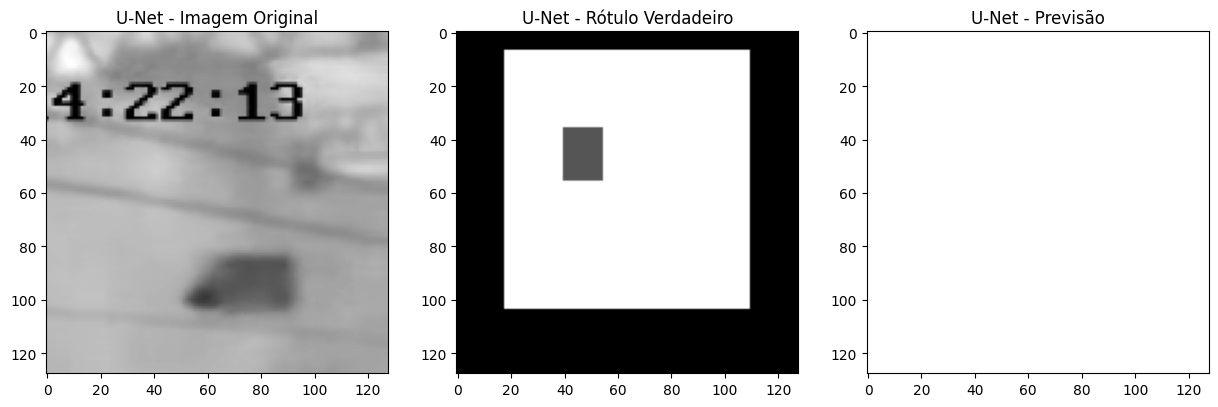

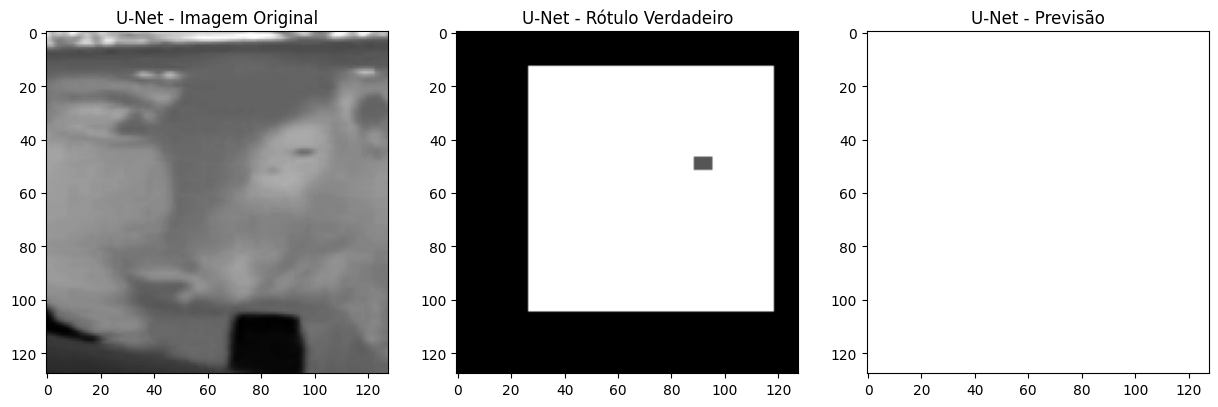

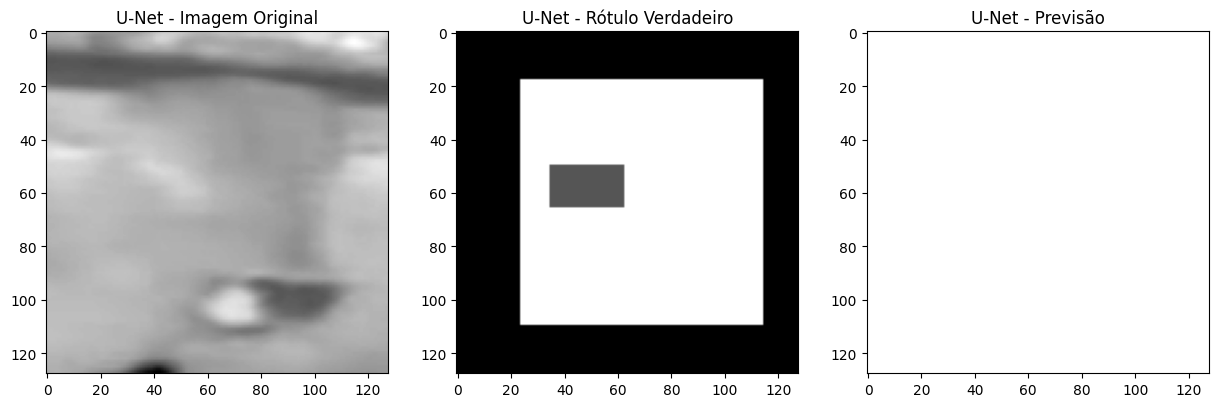

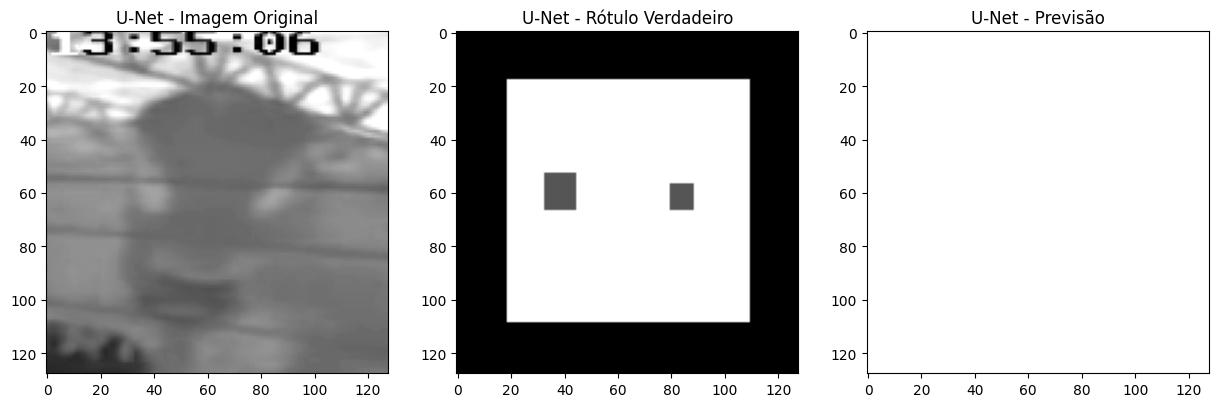

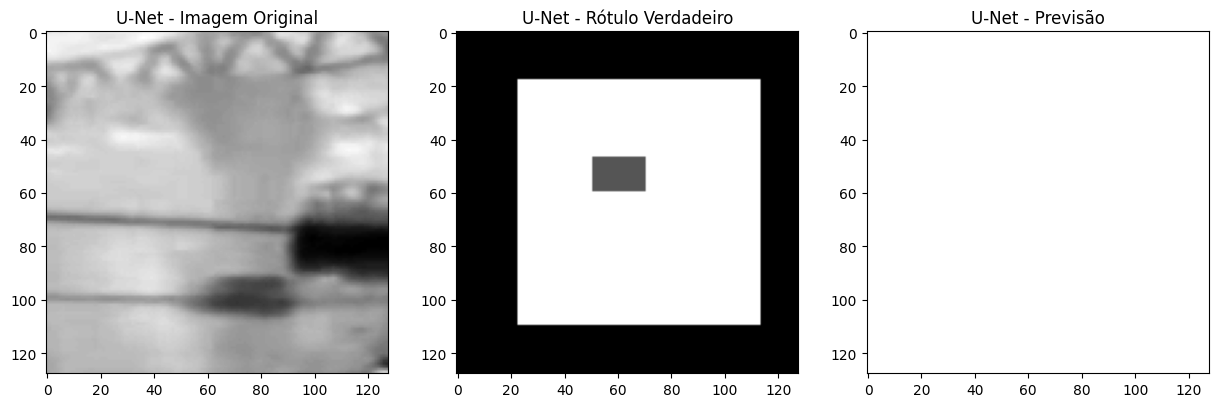

In [17]:
import matplotlib.pyplot as plt

# Função para exibir as imagens originais, as previsões e os rótulos reais
def plot_predictions(X_test, y_test, y_pred, model_name, num_samples=5):
    """
    Plota as imagens originais, os rótulos verdadeiros e as previsões para comparação.

    Parâmetros:
    X_test: Imagens de teste
    y_test: Rótulos verdadeiros
    y_pred: Rótulos preditos
    model_name: Nome do modelo que fez as previsões
    num_samples: Número de amostras para exibir
    """
    for i in range(num_samples):
        plt.figure(figsize=(15, 5))

        # Imagem original (X) - RGB
        plt.subplot(1, 3, 1)
        if X_test[i].shape[-1] == 3:  # Se a imagem for RGB
            plt.imshow(X_test[i])
        else:  # Se for escala de cinza
            plt.imshow(X_test[i].reshape(128, 128), cmap='gray')
        plt.title(f'{model_name} - Imagem Original')

        # Rótulo verdadeiro (Y) - Escala de cinza
        plt.subplot(1, 3, 2)
        plt.imshow(y_test[i].reshape(128, 128), cmap='gray')
        plt.title(f'{model_name} - Rótulo Verdadeiro')

        # Previsão do modelo (Y_pred) - Escala de cinza
        plt.subplot(1, 3, 3)
        plt.imshow(y_pred[i].reshape(128, 128), cmap='gray')
        plt.title(f'{model_name} - Previsão')

        plt.show()


# Avaliação das previsões para cada modelo
# Gerando as predições para cada modelo treinado

y_pred_unet = unet.predict(X_test_normalized)
# y_pred_unetpp = unetpp_model.predict(X_test_normalized)
# y_pred_attention_unet = attention_unet.predict(X_test_normalized)
# y_pred_vgg_unet = vgg16_unet.predict(X_test_rgb)
# y_pred_resnet_unet = resnet_unet_model.predict(X_test_normalized)
# y_pred_segmentation_models = segmentation_model.predict(X_test_normalized)
# y_pred_deeplabv3 = deeplabv3_model.predict(X_test_normalized)
# y_pred_mask_rcnn = mask_rcnn_model.predict(X_test_normalized)
# y_pred_fastfcn = fastfcn_model.predict(X_test_normalized)
# y_pred_gated_scnn = gated_scnn_model.predict(X_test_normalized)
# y_pred_yolov8 = yolov8_model.predict(X_test_normalized)

# Exibir as previsões para cada modelo
plot_predictions(X_test_normalized, y_test, y_pred_unet, "U-Net")
# plot_predictions(X_test_normalized, y_test, y_pred_unetpp, "U-Net++")
# plot_predictions(X_test_normalized, y_test, y_pred_attention_unet, "Attention U-Net")
# plot_predictions(X_test_rgb, y_test, y_pred_vgg_unet, "VGG16 + U-Net")
# plot_predictions(X_test_normalized, y_test, y_pred_resnet_unet, "ResNet + U-Net")
# plot_predictions(X_test_normalized, y_test, y_pred_segmentation_models, "Segmentation Models")
# plot_predictions(X_test_normalized, y_test, y_pred_deeplabv3, "DeepLabV3+")
# plot_predictions(X_test_normalized, y_test, y_pred_mask_rcnn, "Mask R-CNN")
# plot_predictions(X_test_normalized, y_test, y_pred_fastfcn, "FastFCN")
# plot_predictions(X_test_normalized, y_test, y_pred_gated_scnn, "Gated-SCNN")
# plot_predictions(X_test_normalized, y_test, y_pred_yolov8, "YOLOv8 Segmentation")


In [ ]:
X_test_normalized.shape

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Medir o tempo de treinamento
start_time = time.time()

training_time = time.time() - start_time
training_hours, training_minutes = divmod(training_time // 60, 60)
print(f"Tempo Total de Treinamento: {int(training_hours)} horas e {int(training_minutes)} minutos")

# Medir o tempo de inferência por imagem
start_time = time.time()
predictions = np.array([model.predict(np.expand_dims(img, axis=0)) for img in X_val])
inference_time = (time.time() - start_time) / len(X_val)
print(f"Tempo Médio de Inferência por Imagem: {inference_time:.4f} segundos")

# Calcular precisão, recall e F1-score
Y_val_binary = (Y_val > 0.5).astype(np.uint8)
predictions_binary = (predictions > 0.5).astype(np.uint8)

# Achando precisão, recall e F1-score para cada imagem
precision = precision_score(Y_val_binary.flatten(), predictions_binary.flatten(), average='binary')
recall = recall_score(Y_val_binary.flatten(), predictions_binary.flatten(), average='binary')
f1 = f1_score(Y_val_binary.flatten(), predictions_binary.flatten(), average='binary')

print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")